In [3]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

from timeit import default_timer as timer
from datetime import timedelta
import math
import random

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
def plot(frame_idx, rewards, losses, sigma, elapsed_time):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('frame %s. reward: %s. time: %s' % (frame_idx, np.mean(rewards[-10:]), elapsed_time))
    plt.plot(rewards)
    if losses or sigma:
        plt.subplot(122)
        plt.title('fidelity')
    if losses:
        plt.plot(losses, 'g')
    if sigma:
        plt.plot(sigma, 'r')
    plt.show()

In [6]:
# (action, reward) distribution for a given "spectator measurement outcome" state
class Context:
    def __init__(self, num_arms, gamma):
        # correspondingly indexed (reward | state, action) set
        # samples from beta(S, F) distribution
        self.reward_posterior_samples = np.ones(num_arms, dtype=np.float64)
        # (successes | arm)
        self.S = np.ones(num_arms, dtype=np.int)
        # (failures | arm)
        self.F = np.ones(num_arms, dtype=np.int)
        # discount factor
        self.gamma = gamma
        
        self.num_arms = num_arms
        
    def reset(self):
        self.S = np.ones(self.num_arms, dtype=np.int)
        self.F = np.ones(self.num_arms, dtype=np.int)
        
    def update_gamma(self, gamma):
        self.gamma = gamma
        
    def resample_rewards(self):
        # ("Thompson") sampling from beta(S, F) distribution for each arm
        # which enables exploration
        for i in range(len(self.reward_posterior_samples)):
            self.reward_posterior_samples[i] = np.random.beta(self.S[i], self.F[i])

    def discount(self):
        self.S = self.gamma * self.S
        self.F = self.gamma * self.F
        
    def update_posterior(self, reward, arm):
        self.discount()
        self.S[arm] += reward
        self.F[arm] += 1-reward

In [7]:
# contextual Thompson Sampling algorithm implementation
class TS:
    def __init__(self, env, initial_gamma=0.99):
        # two contexts -> pos vs neg rotation with respect to a chosen rotational bias
        self.contexts = [Context(env.num_arms, initial_gamma), Context(env.num_arms, initial_gamma)]
        
        self.rewards = []
        self.fidelity = []
        self.control_fidelity = []
        
        self.num_context_spectators = env.num_context_spectators
        
        self.action_distribution_width = np.pi
        self.action_contextual_bias = 0
        
        
    def get_action(self, observation):
        # our context is an array of binary spectator qubit measurements
        # hence, we could convert this binary array to an integer and index 2^(spectator qubits) contexts
        # context = self.contexts[np.packbits(observation, bitorder='little')[0]] 
        # for now, we only have two contexts (+ vs -), and so we consider spectators to be indistinguishable noise polling devices
        # in the future, we may consider noise gradients and so we do indeed need to track the specific arrangement
    
        context_idx = 1 if np.sum(observation) > self.num_context_spectators / 2 else 0
        context = self.contexts[context_idx]
        context.resample_rewards()
        
        ## to update the gamma or action space, use the functions below e.g. _update_action_distribution_width
        ## this will ensure that the contextual history is reset once the historical correspondence between arms and particular thetas is nullified
        
        # (quantile, uniform action distribution width, rotational bias)
        return (np.argmax(context.reward_posterior_samples), self.action_distribution_width, self.action_contextual_bias)
    
    def _update_gammas(self, gamma):
        for context in self.contexts:
            context.update_gamma(gamma)
        
    def _update_action_distribution_width(self, width):
        self.action_distribution_width = width
        for context in self.contexts:
            context.reset()
        
    def _update_contextual_bias(self, bias):
        self.update_contextual_bias = bias
        for context in self.contexts:
            context.reset()
    
    def update(self, action, reward, observation):
        arm, _, _ = action
        context_idx = 1 if np.sum(observation) > self.num_context_spectators / 2 else 0
        context = self.contexts[context_idx]
        context.update_posterior(reward, arm)
            
    def save_reward(self, reward):
        self.rewards.append(reward)

    def save_fidelity(self, fidelity):
        self.fidelity.append(fidelity)
        
    def save_control_fidelity(self, fidelity):
        self.control_fidelity.append(fidelity)

In [21]:
num_samples = 100


# add some random harmonics
# time_dependent_fn = np.vectorize(lambda x: (2/5) * np.pi * np.sin(2 * np.pi * x / M))
error_samples = np.random.normal(0.0, np.pi / 4, num_samples) # + time_dependent_fn(np.arange(M))

In [100]:
from spectator_env import SpectatorEnv

# describes MDP
# - states are given in terms of a 64 bit measurement outcomes
# - action space is given by (num_arms, uniform_action_space_width, contextual_measurement_bias) i.e. \ZZ_{num_arms} \times U(1) \times U(1)
env = SpectatorEnv(error_samples, num_context_spectators=1, num_reward_spectators=64, num_arms=5)

# from stable_baselines.common.env_checker import check_env
# check_env(env)

/Users/swarnadeepmajumder/anaconda3/envs/MAB/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [95]:
# print(error_samples)


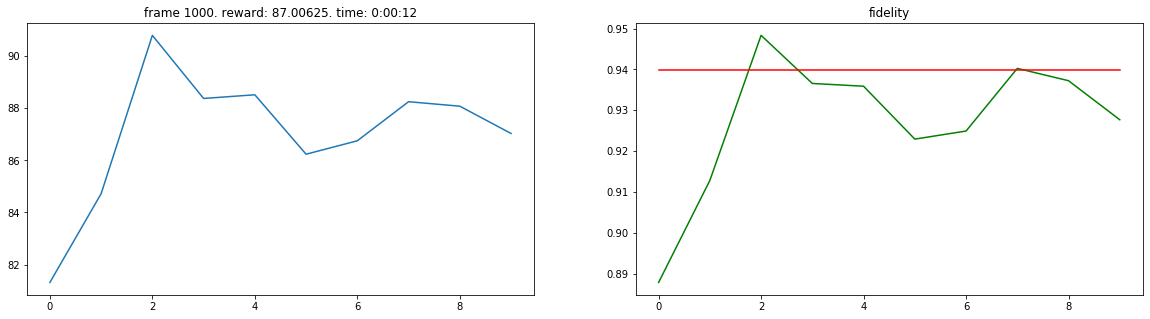

100%|██████████| 100/100 [20:29<00:00, 12.30s/it]


In [101]:
from tqdm import trange
iteration = 100
num_episodes = 10
MAX_FRAMES = num_episodes * num_samples
control_fidelity_traj = np.zeros((iteration,num_episodes))
episode_fidelity_traj = np.zeros((iteration,num_episodes))

for i in trange(iteration):
    start=timer()

    ts = TS(env, initial_gamma=1.0)

    episode_reward = 0
    episode_fidelity = []
    control_fidelity = []

    episode_fidelity_cumulative = []
    control_fidelity_cumulative = []

    j = 0

    # "episodes" are a reasonable way to think about learning a periodic time dependent function
    # max frames = episode length * num episodes
    # episodes are identical sequences of training data
    observation = env.reset()
    for frame_idx in range(1, MAX_FRAMES + 1):
    #     epsilon = config.epsilon_by_frame(frame_idx)

        action = ts.get_action(observation)
        prev_observation = observation
    #     print("prev obs: ", prev_observation)
    #     print("action: ", action)
        observation, reward, done, info = env.step(action)
    #     print("reward: ", reward)
        observation = None if done else observation

        # generally, in RL we would consider r(s | s', a) given a state transition s' -> s due to action a
        # for now, we are only interested in r(s', a)
        ts.update(action, reward, prev_observation)
    #     print(ts.contexts[0].S, ts.contexts[0].F)
    #     print(ts.contexts[1].S, ts.contexts[1].F)
        episode_reward += reward

        episode_fidelity.append(info[0])
        control_fidelity.append(info[1])

        episode_fidelity_cumulative.append(info[0])
        control_fidelity_cumulative.append(info[1])
        if done:
            observation = env.reset()
            ts.save_reward(episode_reward)
            ts.save_fidelity(np.mean(episode_fidelity))
            ts.save_control_fidelity(np.mean(control_fidelity))
            control_fidelity_traj[i,j] = np.mean(control_fidelity)
            episode_fidelity_traj[i,j] = np.mean(episode_fidelity)
            j = j+1
            episode_reward = 0
            episode_fidelity = []
            control_fidelity = []
            # plot grouped by episode
            plot(frame_idx, ts.rewards, ts.fidelity, ts.control_fidelity, timedelta(seconds=int(timer()-start)))
            


    env.close()


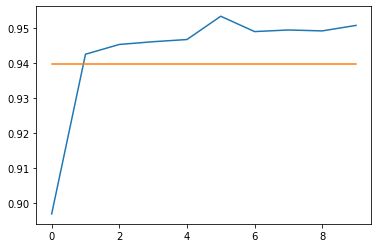

In [45]:
plt.plot(np.mean(episode_fidelity_traj, axis=0))
plt.plot(np.mean(control_fidelity_traj, axis=0))

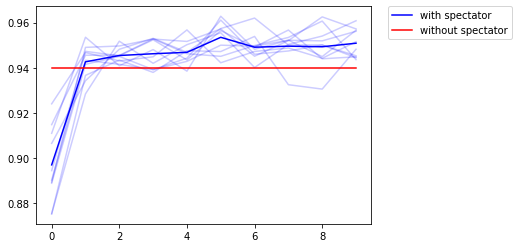

In [64]:
for i in range(episode_fidelity_traj.shape[0]):
    plt.plot(episode_fidelity_traj[i],'b',alpha=0.2)
plt.plot(np.mean(episode_fidelity_traj, axis=0),'b',label='with spectator')
plt.plot(np.mean(control_fidelity_traj, axis=0),'r',label='without spectator')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

Text(0.5, 1.0, 'Error=normal(0,pi/4),#error_sample=100,#episode=10,#iter=100,#context_spec=5,#reward_spec=1,#num_arms=5,NOT-Adaptive')

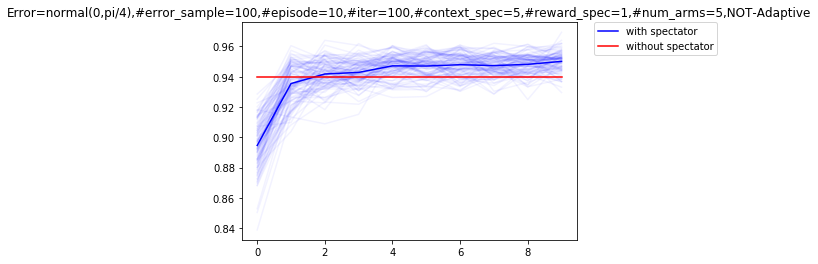

In [84]:
for i in range(episode_fidelity_traj.shape[0]):
    plt.plot(episode_fidelity_traj[i],'b',alpha=0.05)
plt.plot(np.mean(episode_fidelity_traj, axis=0),'b',label='with spectator')
plt.plot(np.mean(control_fidelity_traj, axis=0),'r',label='without spectator')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Error=normal(0,pi/4),#error_sample=100,#episode=10,#iter=100,#context_spec=5,#reward_spec=1,#num_arms=5,NOT-Adaptive")

Text(0.5, 1.0, 'Error=normal(0,pi/4),#error_sample=100,#episode=10,#iter=10,#context_spec=1,#reward_spec=5,#num_arms=5,NOT-Adaptive')

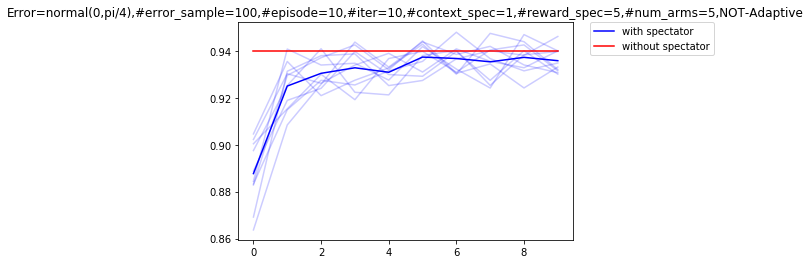

In [76]:
for i in range(episode_fidelity_traj.shape[0]):
    plt.plot(episode_fidelity_traj[i],'b',alpha=0.2)
plt.plot(np.mean(episode_fidelity_traj, axis=0),'b',label='with spectator')
plt.plot(np.mean(control_fidelity_traj, axis=0),'r',label='without spectator')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Error=normal(0,pi/4),#error_sample=100,#episode=10,#iter=10,#context_spec=1,#reward_spec=5,#num_arms=5,NOT-Adaptive")

Text(0.5, 1.0, 'Error=normal(0,pi/4),#error_sample=100,#episode=10,#iter=100,#context_spec=64,#reward_spec=64,#num_arms=5,NOT-Adaptive')

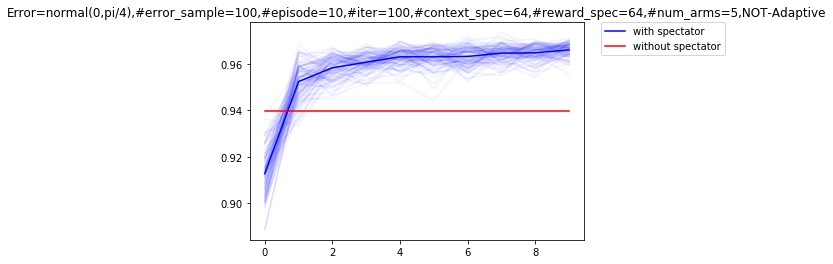

In [88]:
for i in range(episode_fidelity_traj.shape[0]):
    plt.plot(episode_fidelity_traj[i],'b',alpha=0.05)
plt.plot(np.mean(episode_fidelity_traj, axis=0),'b',label='with spectator')
plt.plot(np.mean(control_fidelity_traj, axis=0),'r',label='without spectator')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Error=normal(0,pi/4),#error_sample=100,#episode=10,#iter=100,#context_spec=64,#reward_spec=64,#num_arms=5,NOT-Adaptive")

Text(0.5, 1.0, 'Error=normal(0,pi/4),#error_sample=100,#episode=10,#iter=100,#context_spec=64,#reward_spec=64,#num_arms=5,NOT-Adaptive')

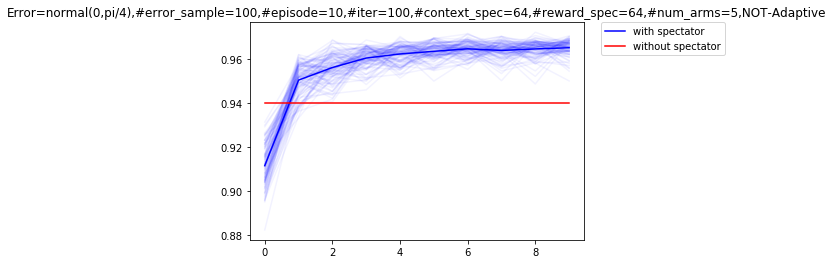

In [98]:
episode_fidelity_traj_64_64 = episode_fidelity_traj
control_fidelity_traj_64_64 = control_fidelity_traj
for i in range(episode_fidelity_traj_64_64.shape[0]):
    plt.plot(episode_fidelity_traj_64_64[i],'b',alpha=0.05)
plt.plot(np.mean(episode_fidelity_traj_64_64, axis=0),'b',label='with spectator')
plt.plot(np.mean(control_fidelity_traj_64_64, axis=0),'r',label='without spectator')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Error=normal(0,pi/4),#error_sample=100,#episode=10,#iter=100,#context_spec=64,#reward_spec=64,#num_arms=5,NOT-Adaptive")

Text(0.5, 1.0, 'Error=normal(0,pi/4),#error_sample=100,#episode=10,#iter=100,#context_spec=64,#reward_spec=1,#num_arms=5,NOT-Adaptive')

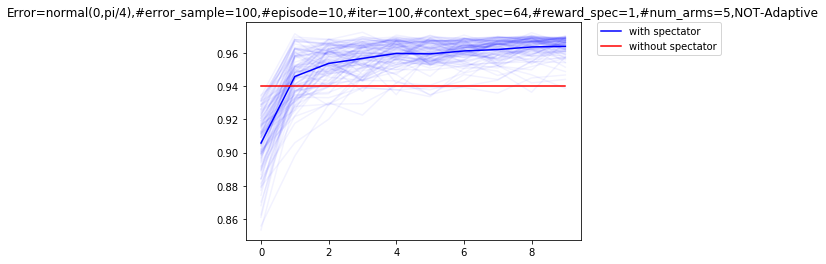

In [93]:
episode_fidelity_traj_64_1 = episode_fidelity_traj
control_fidelity_traj_64_1 = control_fidelity_traj
for i in range(episode_fidelity_traj_64_1.shape[0]):
    plt.plot(episode_fidelity_traj_64_1[i],'b',alpha=0.05)
plt.plot(np.mean(episode_fidelity_traj_64_1, axis=0),'b',label='with spectator')
plt.plot(np.mean(control_fidelity_traj_64_1, axis=0),'r',label='without spectator')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Error=normal(0,pi/4),#error_sample=100,#episode=10,#iter=100,#context_spec=64,#reward_spec=1,#num_arms=5,NOT-Adaptive")

Text(0.5, 1.0, 'Error=normal(0,pi/4),#error_sample=100,#episode=10,#iter=100,#context_spec=1,#reward_spec=64,#num_arms=5,NOT-Adaptive')

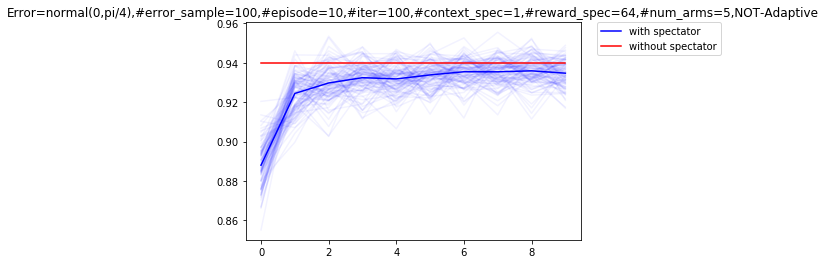

In [102]:
episode_fidelity_traj_1_64 = episode_fidelity_traj
control_fidelity_traj_1_64 = control_fidelity_traj
for i in range(episode_fidelity_traj_1_64.shape[0]):
    plt.plot(episode_fidelity_traj_1_64[i],'b',alpha=0.05)
plt.plot(np.mean(episode_fidelity_traj_1_64, axis=0),'b',label='with spectator')
plt.plot(np.mean(control_fidelity_traj_1_64, axis=0),'r',label='without spectator')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Error=normal(0,pi/4),#error_sample=100,#episode=10,#iter=100,#context_spec=1,#reward_spec=64,#num_arms=5,NOT-Adaptive")

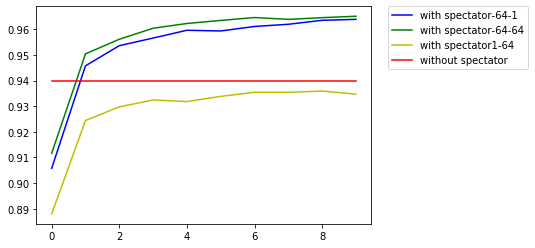

In [105]:
#compare
#with/without spectator #context-#reward
plt.plot(np.mean(episode_fidelity_traj_64_1, axis=0),'b',label='with spectator-64-1')
plt.plot(np.mean(episode_fidelity_traj_64_64, axis=0),'g',label='with spectator-64-64')
plt.plot(np.mean(episode_fidelity_traj_1_64, axis=0),'y',label='with spectator1-64')
plt.plot(np.mean(control_fidelity_traj_64_1, axis=0),'r',label='without spectator')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [11]:
print(ts.contexts[0].S, ts.contexts[0].F)
print(ts.contexts[0].reward_posterior_samples)

[ 15.15625  145.265625  29.078125   5.6875     1.828125] [ 4.84375  11.734375  6.921875  3.3125    2.171875]
[0.78314748 0.94060762 0.91646844 0.66698341 0.17938554]


In [12]:
print(ts.contexts[1].S, ts.contexts[1].F)
print(ts.contexts[1].reward_posterior_samples)

[  1.296875   4.21875   15.53125  238.53125    7.71875 ] [ 2.703125  3.78125   3.46875  13.46875   3.28125 ]
[0.6862884  0.41028654 0.67299448 0.93080145 0.70845661]


{'whiskers': [<matplotlib.lines.Line2D at 0x1a2dbe1050>,
 'caps': [<matplotlib.lines.Line2D at 0x1a2dbe1b50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a2d3b4290>,
 'medians': [<matplotlib.lines.Line2D at 0x1a2dc105d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a2dc10ad0>,
 'means': []}

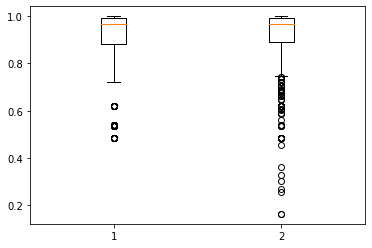

In [15]:
data=[control_fidelity_cumulative,episode_fidelity_cumulative]
plt.boxplot(data)

In [18]:
episode = 1
np.mean(episode_fidelity_cumulative),np.mean(control_fidelity_cumulative)

(0.9231472638199771, 0.9221677181292555)

In [84]:
#calculate the moving average
#Y is moving average 
y = control_fidelity
def moving_average(y,r=10):
    Y = np.zeros(len(y))

    r = 10

    for i in range(len(Y)):
        #For the first 5 points just store it's value as we cannot take moving average
        if i<=r:
            Y[i] = y[i]
        else: 
            Y[i] = (1/(2*r))*np.sum(y[i-r:i+r])
    return Y

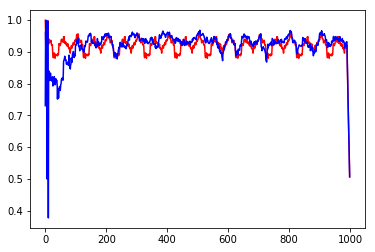

In [110]:
plt.plot(moving_average(control_fidelity_cumulative),'r')
plt.plot(moving_average(episode_fidelity_cumulative),'b')
#plt.xlim(10,800)
#plt.ylim(0.8,1)

In [1]:
plt.plot(error_samples)

NameError: name 'plt' is not defined

In [96]:
np.mean(episode_fidelity)

0.9161277093385984

In [97]:
np.mean(control_fidelity)

0.924867734240257

In [104]:
control_fidelity_cumulative

[0.9475373224636076,
 0.9999773984689053,
 0.8075494424878735,
 0.9911602026263114,
 0.9664850076644013,
 0.9528524240581032,
 0.7804149775938012,
 0.8894789885005083,
 0.7303368071576075,
 0.9994247661066714,
 0.9997536941959131,
 0.9864960325207097,
 0.8823394647596621,
 0.9663712066567377,
 0.9635171362087134,
 0.9988078814321445,
 0.9898199371519835,
 0.9903032446497451,
 0.9966875417398972,
 0.9889746622258513,
 0.9972626945103944,
 0.9965012655800121,
 0.9065237923958107,
 0.9565294275504465,
 0.906623574133627,
 0.9569945452092832,
 0.958601912500014,
 0.990855294838992,
 0.9783144859115759,
 0.8697852537989503,
 0.9960344671942962,
 0.9340685387744985,
 0.4768260026328585,
 0.9711446944022155,
 0.9887334252044894,
 0.9931773199801831,
 0.9478594772612076,
 0.9997962351942113,
 0.9721022070065118,
 0.9901955921529565,
 0.980439328827918,
 0.9462068551003318,
 0.948964320247301,
 0.9958133130429438,
 0.9934185961127917,
 0.9269471804144145,
 0.9724342512779005,
 0.995539487952931